# Dont overfit Implementation using Regresion algo from sklearn Library

## Competition Details
#### Link: https://www.kaggle.com/c/dont-overfit-ii
#### Best sklearn Result: 0.845 accuracy

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc,os,sys

In [9]:

train = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')


print(train.shape, test.shape)

for c in train.columns:
    if c not in test.columns: print(c)



train.head()


(250, 302) (19750, 301)
target


,id,target,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,0,1.0,-0.098,2.165,0.681,-0.614,1.309,-0.455,-0.236,0.276,...,0.867,1.347,0.504,-0.649,0.672,-2.097,1.051,-0.414,1.038,-1.065
1,1,0.0,1.081,-0.973,-0.383,0.326,-0.428,0.317,1.172,0.352,...,-0.165,-1.695,-1.257,1.359,-0.808,-1.624,-0.458,-1.099,-0.936,0.973
2,2,1.0,-0.523,-0.089,-0.348,0.148,-0.022,0.404,-0.023,-0.172,...,0.013,0.263,-1.222,0.726,1.444,-1.165,-1.544,0.004,0.800,-1.211
3,3,1.0,0.067,-0.021,0.392,-1.637,-0.446,-0.725,-1.035,0.834,...,-0.404,0.640,-0.595,-0.966,0.900,0.467,-0.562,-0.254,-0.533,0.238
4,4,1.0,2.347,-0.831,0.511,-0.021,1.225,1.594,0.585,1.509,...,0.898,0.134,2.415,-0.996,-1.006,1.378,1.246,1.478,0.428,0.253


null count: Series([], dtype: int64)


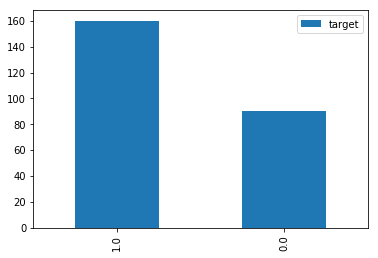

In [10]:
null_cnt = train.isnull().sum().sort_values()
print('null count:', null_cnt[null_cnt > 0])


train['target'].value_counts().to_frame().plot.bar()

In [11]:
all_data = train.append(test, sort=False).reset_index(drop=True)
del train, test
gc.collect()

all_data.head()

,id,target,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,0,1.0,-0.098,2.165,0.681,-0.614,1.309,-0.455,-0.236,0.276,...,0.867,1.347,0.504,-0.649,0.672,-2.097,1.051,-0.414,1.038,-1.065
1,1,0.0,1.081,-0.973,-0.383,0.326,-0.428,0.317,1.172,0.352,...,-0.165,-1.695,-1.257,1.359,-0.808,-1.624,-0.458,-1.099,-0.936,0.973
2,2,1.0,-0.523,-0.089,-0.348,0.148,-0.022,0.404,-0.023,-0.172,...,0.013,0.263,-1.222,0.726,1.444,-1.165,-1.544,0.004,0.800,-1.211
3,3,1.0,0.067,-0.021,0.392,-1.637,-0.446,-0.725,-1.035,0.834,...,-0.404,0.640,-0.595,-0.966,0.900,0.467,-0.562,-0.254,-0.533,0.238
4,4,1.0,2.347,-0.831,0.511,-0.021,1.225,1.594,0.585,1.509,...,0.898,0.134,2.415,-0.996,-1.006,1.378,1.246,1.478,0.428,0.253


In [12]:
# drop constant column
constant_column = [col for col in all_data.columns if all_data[col].nunique() == 1]
print('drop columns:', constant_column)
all_data.drop(constant_column, axis=1, inplace=True)

drop columns: []


In [13]:
corr_matrix = all_data.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [c for c in upper.columns if any(upper[c] > 0.95)]
del upper

drop_column = all_data.columns[to_drop]
print('drop columns:', drop_column)
all_data.drop(drop_column, axis=1, inplace=True)

drop columns: Index([], dtype='object')


In [14]:
cols = [col for col in all_data.columns if col not in ['id','target']]
for i, t in all_data.loc[:, cols].dtypes.iteritems():
    if t == object:
        print(i)
        all_data[i] = pd.factorize(all_data[i])[0]

In [16]:
from sklearn import preprocessing

numcols = all_data.drop(['id','target'],axis=1).select_dtypes(include='number').columns.values
scaler = preprocessing.StandardScaler()
all_data.loc[:,numcols] = scaler.fit_transform(all_data[numcols])

X_train = all_data[all_data['target'].notnull()].reset_index(drop=True)
X_test = all_data[all_data['target'].isnull()].drop(['target'], axis=1).reset_index(drop=True)
del all_data
gc.collect()

28

In [17]:
# drop ID_code
X_train.drop(['id'], axis=1, inplace=True)
X_test_ID = X_test.pop('id')

Y_train = X_train.pop('target')

print(X_train.shape, X_test.shape)

(250, 300) (19750, 300)


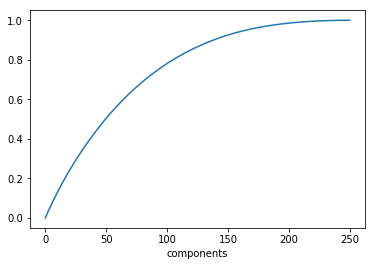

In [18]:

from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train)
ev_ratio = pca.explained_variance_ratio_
ev_ratio = np.hstack([0,ev_ratio.cumsum()])

plt.xlabel('components')
plt.plot(ev_ratio)
plt.show()

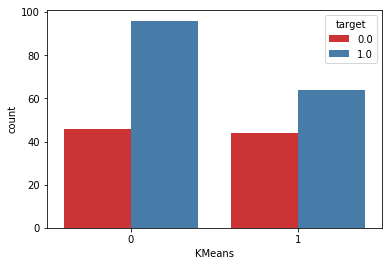

In [19]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=2, init='k-means++', max_iter=3000, random_state=42)
X_train_km = km.fit_predict(X_train)
X_test_km = km.predict(X_test)

km_data = pd.DataFrame({'KMeans':X_train_km, 'target':Y_train})
sns.countplot(x='KMeans', hue='target', palette='Set1', data=km_data)



In [20]:

from imblearn.over_sampling import SMOTE,ADASYN

#sm = SMOTE(random_state=42)
#sm = SMOTE(kind='svm',random_state=42)
#sm = SMOTE(kind='borderline1',random_state=42)
sm = ADASYN(random_state=42)
X_train, Y_train = sm.fit_sample(X_train, Y_train)
X_train = pd.DataFrame(X_train, columns=X_test.columns)
print(X_train.shape)

(335, 300)


In [22]:
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE


folds = RepeatedStratifiedKFold(n_splits=10, n_repeats=20, random_state=42)
oof_preds = np.zeros(X_train.shape[0])
sub_preds = np.zeros(X_test.shape[0])

for fold_, (trn_, val_) in enumerate(folds.split(X_train, Y_train)):
    trn_x, trn_y = X_train.iloc[trn_], Y_train[trn_]
    val_x, val_y = X_train.iloc[val_], Y_train[val_]

    '''
    log_clf = LogisticRegression(C=0.3, max_iter=1000, class_weight='balanced', 
            penalty='l1', solver='liblinear', random_state=42)
    model = RFE(log_clf, 25, step=1)
    model.fit(trn_x, trn_y)
    oof_preds[val_] = model.predict_proba(val_x)[:,1]
    sub_preds += model.predict_proba(X_test)[:,1] / 10 / 20 #folds.n_splits
    '''

    log_clf = Lasso(alpha=0.03, tol=0.01, selection='random', random_state=42)
    model = RFE(log_clf, 20, step=1)
    model.fit(trn_x, trn_y)
    oof_preds[val_] = model.predict(val_x).clip(0, 1)
    sub_preds += model.predict(X_test).clip(0, 1) / 10 / 20 #folds.n_splits



,id,target
0,250,0.720459
1,251,0.529408
2,252,0.580964
3,253,0.795048
4,254,0.498343


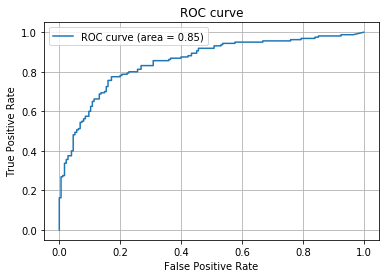

In [23]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(Y_train, oof_preds)
auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)


submission = pd.DataFrame({
    'id': X_test_ID,
    'target': sub_preds
})
submission.to_csv("submissions/sklearn_regresion.csv", index=False)


submission.head()